# Проект: определение факторов успешности компьютерных игр.

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Перед вами данные до 2016 года. 

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков». Данные за 2016 год могут быть неполными.

# Описание данных

Данные находятся в файле '/datasets/games.csv'.

Признаки:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


- важно: данные за 2016 год могут быть неполными.

# План работы

- Загрузить, изучить и подготовить данные для анализа
- Провести исследовательский анализ данных
- Составить портрет пользователя каждого региона
- Проверить две гипеотезы
- Сформировать промежуточные и общий выводы

## Изучение данных

In [1]:
#импортируем необходимые модули для работы
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# отключаем предупреждения, так как они не влияют на работу, а отвлекают
warnings.filterwarnings('ignore')

In [2]:
# загружаем данные либо с локального диска, либо с сервера
try:
    games = pd.read_csv('С://Users//HOMMANDER//Documents//games.csv')  # Локальный путь
except:
    games = pd.read_csv('/datasets/games.csv')  # Серверный путь

In [3]:
display(games.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

### Вывод 
1. Присутствует два пропуска в полях Name и Genre, скорее всего в одних и тех же строках. Их проще удалить.
2. 250 пропусков в колонке Year_of_Release как вариант вытащить дату из названия игры, либо загрузить из интернет, остальное удалить. Любая расчетная замена сильно исказит данные, оставить пустоты нельзя, та как на данных этой колонки завязаны многие расчты, поэтом в крайнем случае придется удалить. У этой колонки также необходимо изменить тип даных на целочисленный.
3. Critic_Score большой количество пропусков по неизвестной причине. Возможно в ранние годы статистика не собиралась, возможно у источника информации не было достоверных сведений по этому показателю, так как рейтинг не является ни обязательным, ни централизованным неудивительно, что многие игры такого рейтинга не имеют. В базовом датафрейме лучше оставить как есть. При необходимости нужно выделить срез с присутствующими данными и работать с ним отдельно.
4. User_Score в колонке также большое количество пропусков, работаем с ним аналогично предыдущему, кроме того присутствует такой показатель как tbd - To Be Determined, то есть "Будет определено". Обозначающий неясность, не определенность в настоящий момент. Таких строк всего 12. Я предполагаю как и обычные пропуски не включать строки с tbd в срез для анализа, а данные из колонки перевести в формат float, предварительно удалив оттуда tbd. 
5. Rating - ESRB колонка имеет также большое число пропусков. Причин несколько а) Часть игр вышла до начала использования этого рейтинга б) Рейтинг не является обязательным в)Рейтинг изначально развивался в США и Канаде поэтому игры распространяеме в других регионах его не используют. Рейтинг качественный, не числовой и само отсутствие рейтинга также информация для анализа, поэтому пропуски лучше заполнить, например строкой 'not_rating'.
6. Наименования колонок меняем на такие же со строчными символами.
7. Необходимо проверить значения колонок с качественными значениями на неявные дубликаты.

## Предобработка данных

In [4]:
# наименования колонки делаем с маленькой буквы
games = games.rename(columns={'Name':'name','Platform':'platform','Year_of_Release':'year_of_release','Genre':'genre',
                             'NA_sales':'na_sales', 'EU_sales':'eu_sales', 'JP_sales':'jp_sales', 'Other_sales':'other_sales',
                             'Critic_Score':'critic_score', 'User_Score':'user_score', 'Rating':'rating'})

**Комментарий** Неявных дубликатов в наименованиях платформ не увидел

In [5]:
display(games['platform'].unique())

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

**Комментарий** Неявных дубликатов в жанре также нет 

In [6]:
display(games['genre'].unique())

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

**Комментарий** Смотрим что за два пропуска в колонках с жанром и названием игр. Несущественные данные, мизерные продажи - удаляем.

In [7]:
display(games[games['genre'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [8]:
# Всего две строки с отсутствующим именем игры, жанром и с мизерными продажами. Удаляем 
games = games.dropna(subset = ['name'])

In [9]:
# создаем столбец 'cumul_sales' с общими продажами
games['cumul_sales'] = games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

In [10]:
display(games['user_score'].unique())

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

**Комментарий** tbd рейтинг, рейтинг еще не определен, или будет определен после выхода игры. Полагаю, что его также как и NaN нет необходимости учитывать при анализе зависимости продаж от величины рейтинга. Но удалять строки из базового датафрейма как и с NaN сейчас не будем, так как это более чем на 50% сократит информативность полученных данных, просто сделаем два локальных датафрейма-среза df_usecore и df_criticore с вырезанными NaN и tbd. Будем использовать их в тех случаях, когда нам понадобятся данные из этих колонок.

In [11]:
#df_usecore: датасет-срез по данным с оценками пользователей без tbd
df_usecore = games[games['user_score']!='tbd'].dropna(subset = ['user_score'])
df_usecore['user_score'] = df_usecore['user_score'].astype('float')

#df_criticore: датасет-срез по дпнным с оценками критиков 
df_criticore = games.dropna(subset = ['critic_score'])

#в колонке 'rating' заменяем пропуски на 'not_rating'
games['rating'] = games['rating'].fillna('not_rating')

**Комментарий** в колонке 'year_of_release' заменяем часть пропусков данными из названия. Для этого используем функцию replace_year, применяем ее с помощью applay к датасету. Остальные строки с пропусками удаляем. (Хороший вариант с подгрузкой данных из интернета и последующей заменой,  идея оказалась рабочей (проверил на нескольких заменах), но ресурсоемкой и на нее просто не хватило времени)

In [12]:
display(games['year_of_release'].unique())

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

In [13]:
# Заменяем часть пропусков на год из названия игры, если оно его содержит.
def replace_year(row):
    years = {
            '1994':1994, '1998':1998, '1999':1999, '2000':2000, '1997':1997, '1995':1995,
            '2001':2001, '2002':2002, '2003':2003, '2004':2004, '2005':2005, '2006':2006,
            '2007':2007, '2008':2008, '2009':2009, '2010':2010, '2011':2011, '2012':2012,
            '2013':2013, '2014':2014, '2015':2015, '2016':2016, '2017':2017, '2018':2018
            }
    for yr in years:
        if yr in row['name']:
            return years.get(yr)
            
games['year_of_release'] = games['year_of_release'].fillna(games.apply(replace_year, axis=1))

# Удаляем все NaN в колонках с годом реализации. В далнейшем подгрузим их из интернет
games = games.dropna(subset = ['year_of_release'])
games['year_of_release'] = games['year_of_release'].astype('int')

**Комментарий** Проверяем на дубликаты. Дубликатов нет

In [14]:
print(games.duplicated().sum())

0


In [15]:
# избавляемся от tbd
games = games[games['user_score']!='tbd']

# изменяем формат данных c оценками пользователей на float
games['user_score'] = pd.to_numeric(games['user_score'], errors = 'ignore')

In [16]:
display(games.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14083 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             14083 non-null  object 
 1   platform         14083 non-null  object 
 2   year_of_release  14083 non-null  int64  
 3   genre            14083 non-null  object 
 4   na_sales         14083 non-null  float64
 5   eu_sales         14083 non-null  float64
 6   jp_sales         14083 non-null  float64
 7   other_sales      14083 non-null  float64
 8   critic_score     6937 non-null   float64
 9   user_score       7473 non-null   float64
 10  rating           14083 non-null  object 
 11  cumul_sales      14083 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.4+ MB


None

### Вывод 

1. Изменены наименования колонок на строчные символы.
2. Проведена проверка в колонках 'platform' и 'genre' на неявные дубликаты, таких не найдено.
3. Проанализированы пропуски в колонке 'year_of_release'. Произведена частичная замена на данные из названия, остальные удалены. Тип данных изменен на int. 
4. В колонке 'rating' пропуски заменены на 'not_rating' 
5. Дубликатов в таблице нет 
6. Создан столбец 'cumul_sales' c общими продажами игр.
7. Созданы два датафрейма-среза df_usecore и df_criticore со строками содержащими оценки пользователей и критиков без пропусков и tbd.

## Исследовательский анализ данных

**Комментарий** Оцениваем количество выпускаемых игр по годам, с помощью сводной таблицы.

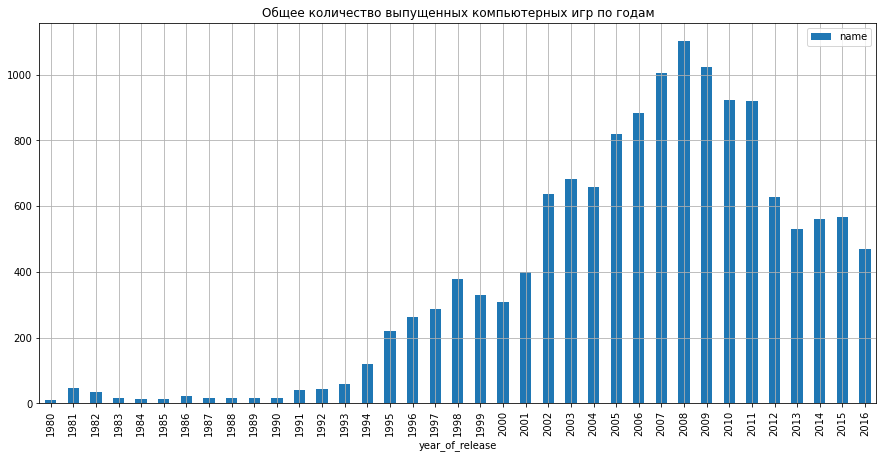

In [17]:
(
    games.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count').
    plot(grid=True,figsize=(15,7), kind = 'bar', title='Общее количество выпущенных компьютерных игр по годам')
);

### Вывод 
Технически,  для анализа и прогноза текущей ситуации по продажам и выпускам игр, данными до 1990 года можно пренебречь. Но точне об этом можно сказать, после изучения истории "жизни" конкретных платформ и игровых жанров.
Для работы делаем рабочий датафрем немного укороченный по годам. Начинаем его с 1991 года. В этой связи интересно посмотреть, что стало с пустотами в колонках с оценками пользователей, критиков и рейтингами.

In [18]:
df = games[games['year_of_release'] > 1990]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13862 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             13862 non-null  object 
 1   platform         13862 non-null  object 
 2   year_of_release  13862 non-null  int64  
 3   genre            13862 non-null  object 
 4   na_sales         13862 non-null  float64
 5   eu_sales         13862 non-null  float64
 6   jp_sales         13862 non-null  float64
 7   other_sales      13862 non-null  float64
 8   critic_score     6935 non-null   float64
 9   user_score       7471 non-null   float64
 10  rating           13862 non-null  object 
 11  cumul_sales      13862 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.4+ MB


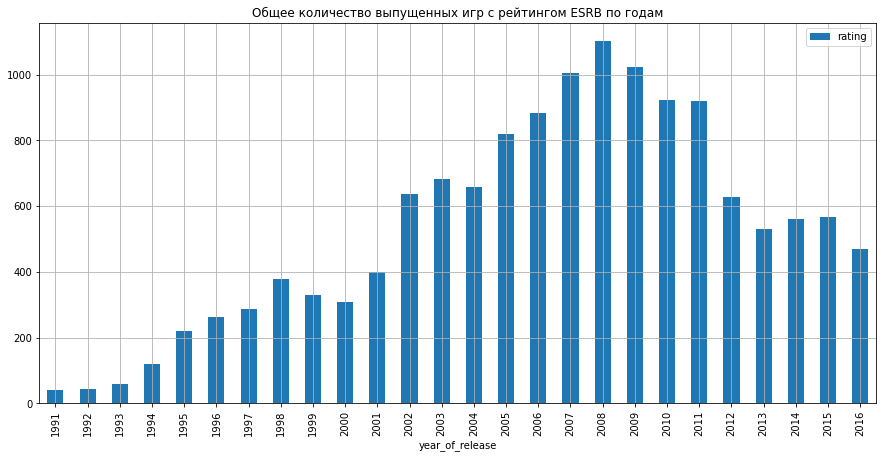

In [19]:
(
    df.pivot_table(index = 'year_of_release', values = 'rating',  aggfunc = 'count').
    plot(grid=True,figsize=(15,7), kind = 'bar', title='Общее количество выпущенных игр с рейтингом ESRB по годам')
);

**Комментарий** количество колонок с оценками практически не изменилось !!!!! Рейтинги появились в существенном количестве только с 1996 года (не удивительно, организация придумавшая всё это была основана в 1994 году). Рейтинги полноценно использовались только с начала двухтысячных годов. Соответственно бессмысленно анализировать рейтинги игр и их зависимости на продажи до этого периода. Этот факт также подтверждает предположение о том, что отчасти пропуски в данных с оценками эксертов и пользователей связаны с тем, что таких данных в то время не существовалао в природе.

**Комментарий** Смотрим, как менялись продажи по платформам, с помощью сводной таблице. Сразу видно, лидеров. Но это данные с 1991 года.

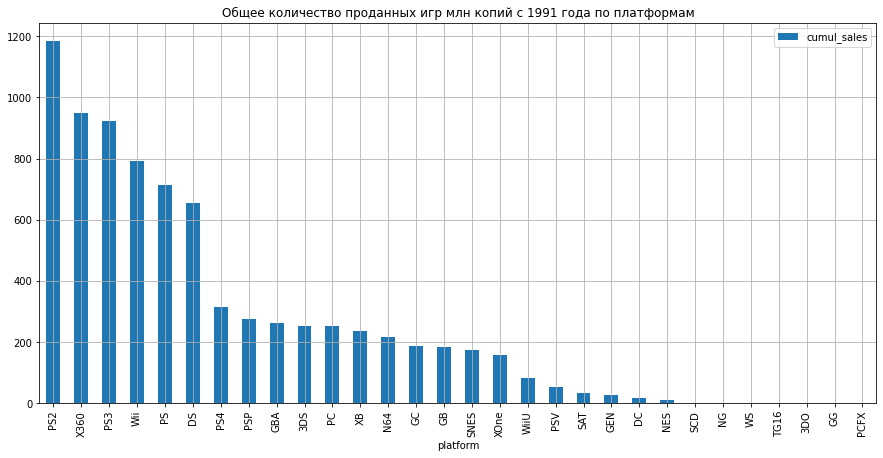

In [20]:
(
    df.pivot_table(index = 'platform', values = 'cumul_sales', aggfunc = 'sum').
    sort_values(by = 'cumul_sales',ascending = False).
    plot(grid=True,figsize=(15,7), kind = 'bar',title='Общее количество проданных игр млн копий с 1991 года по платформам')
);

**Комментарий** Смотрим общее количество проданных игр по ТОП6 платформ за весь период жизни платформы. 6 платформ выбрано для наглядной визуализации на экране. Графики строим в цикле по списку платформ. Для каждой из платформ внутри строится сводная таблица из которой берутся координаты для графика

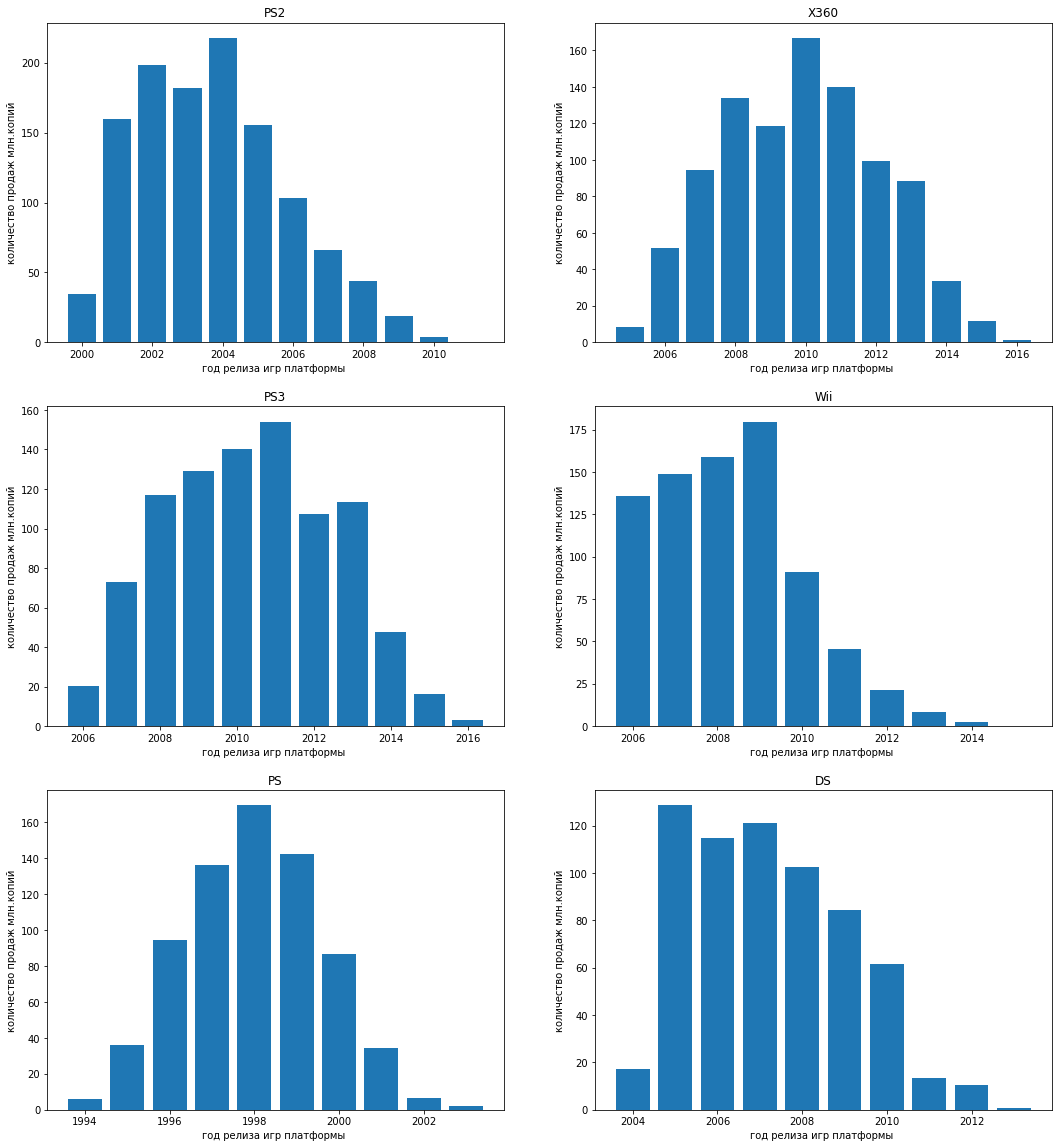

In [21]:
# формируем top6 series с помощью сводной таблицы и сортировки из датафрейма DF
top6 =df.groupby('platform')['cumul_sales'].sum().sort_values(ascending = False).iloc[:6]

f, axs = plt.subplots(3, 2, figsize=(18, 20))

#индексы для построения и перебора массива экранов для вывода графиков
index, subplt, subscr = 0, 0, 0
for platforma in top6.index:
# xy - сводная таблица для каждой платформы. данные по платформе фильтруются с помощью query
# индексы этой таблицы, год - координата х, а координата y - сумма продаж по выбранной платформе за этот год
    xy = df.query('platform == @platforma').pivot_table(index='year_of_release', values='cumul_sales', aggfunc='sum')
    axs[subplt,subscr].bar(xy.index, xy['cumul_sales'], linewidth=0.7)
    axs[subplt,subscr].set_title(platforma)
    axs[subplt,subscr].set_xlabel('год релиза игр платформы ')
    axs[subplt,subscr].set_ylabel('количество продаж млн.копий')
    index += 1
    subscr = index%2
    subplt = index//2
plt.show; 

### Вывод  
Цикл жизни игровой платформы 9 - 11 лет. За это время платформа появляется, растет, затем падает и исчезает.При этом 4-5 лет рост, затем 1-2 года пик продаж и 4 - 5 лет падение. Можно предсказать на каком этапе жизненного цикла сейчас находится игровая платформа если есть полные данные о количестве проданных копий за последние 4-5 лет. Поэтому актуальный период принимаем за 5 лет, и формируем новый рабочий датафрейм df_actuel за период 2012 - 2016 годы. 

Для выбора потенциально прибыльной игровой платформы смотрим на продажи за последние пять лет. Строим график сводной таблицы по годам реализации.

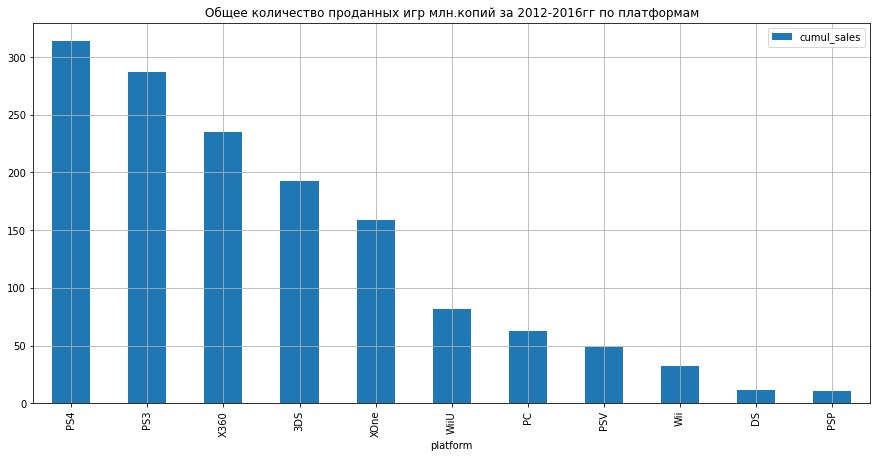

In [22]:
# df_actuel - датафрейм с данными за 2012 - 2016 годы
df_actuel = games[games['year_of_release']>2011].copy()

(
    df_actuel.pivot_table(index = 'platform', values = 'cumul_sales', aggfunc = 'sum').
    sort_values(by = 'cumul_sales',ascending = False).
    plot(grid=True,figsize=(15,7), kind = 'bar', title='Общее количество проданных игр млн.копий за 2012-2016гг по платформам')
);

**Комментарий** Всего 11 платформ на рынке в этот период. Потенциальными могут быть все, в зависимости на каком этапе соей жизни они находятся. Выберем несколько растущих платформ и рассмотрим подробнее. 

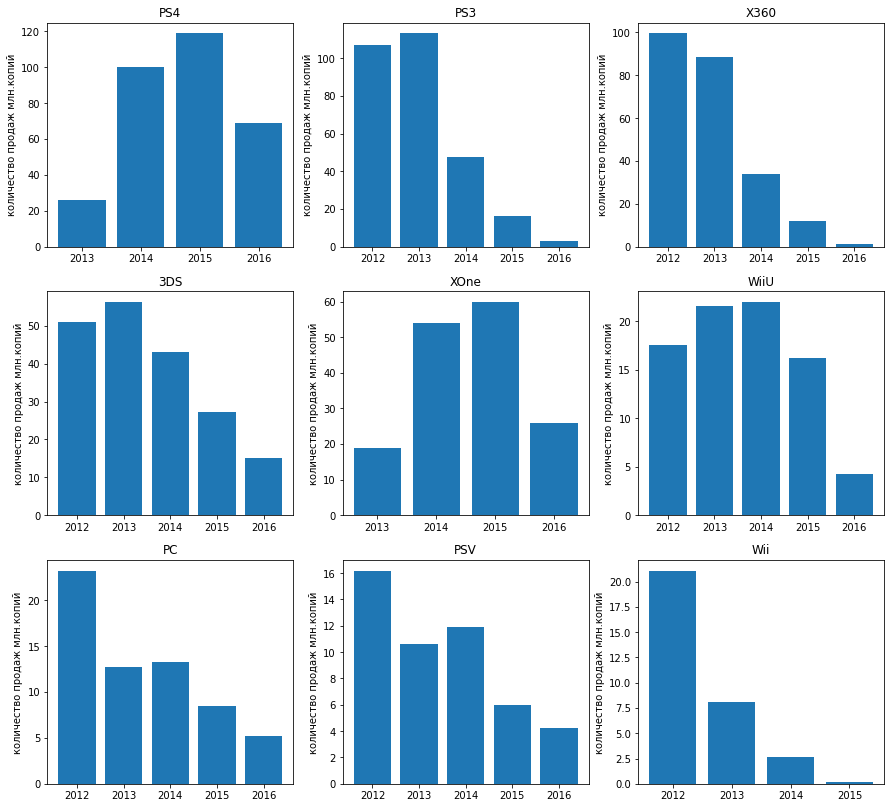

In [23]:
# top9 список платформ. 9 - для наглядного отображения на экране.
top9 =df_actuel.groupby('platform')['cumul_sales'].sum().sort_values(ascending = False).iloc[:9]


f, axs = plt.subplots(3, 3, figsize=(15, 14))
index, subplt, subscr = 0, 0, 0
#['PS4','WiiU','PS3','X360','3DS','XOne','PC','PSV','Wii']
for platforma in top9.index:
    xy = df_actuel.query('platform == @platforma').pivot_table(index='year_of_release', values='cumul_sales', aggfunc='sum')
    axs[subplt,subscr].bar(xy.index, xy['cumul_sales'], linewidth=0.7)
    axs[subplt,subscr].set_title(platforma)
    #axs[subplt,subscr].set_xlabel('год релиза игр платформы ')
    axs[subplt,subscr].set_ylabel('количество продаж млн.копий')
    index += 1
    subscr = index%3
    subplt = index//3
plt.show;    

### Вывод 
С учетом того, что данные за 2016 год не полные, можно сделать вывод, что в этот период растут продажи по платформам игр PS4 и XOne, соответственно их и будем считать потенциальными для инвестициях в 2017 году, и рассматривать в дальнейшем.

Строим  «ящики с усами» по глобальным продажам игр по платформам PS4 и XOne, для сравления пристраиваем "старую" платформу PC и PS2.

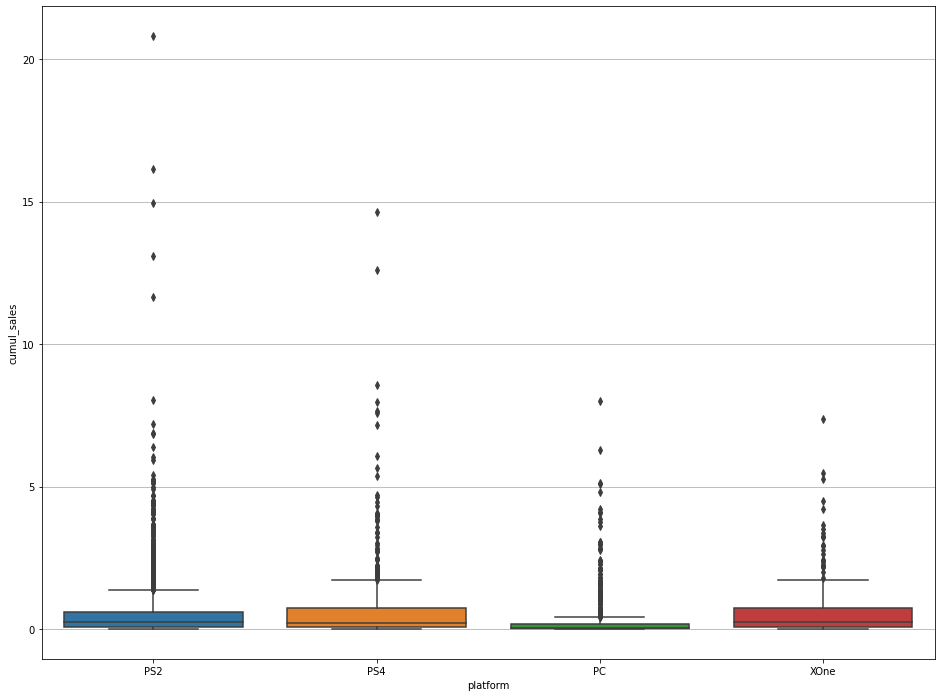

In [24]:
# df_slice - срез с данными по перспективным платформам PS3, XOne и "старичкам" PC, PS2
df_slice = df.query('(platform == "PS4") or (platform =="XOne") or (platform == "PC") or (platform == "PS2")')
plt.figure(figsize=(16,12))
plt.grid()

#Используем boxplot из библиотеки seaborn, так как он легко отрабатывает данные разной длины
sns.boxplot(data = df_slice, x= 'platform', y= 'cumul_sales');

**Комментарий** Конечно это не выбросы, не случайные величины. Это ТОП из ТОПов игр. Тем не менее основная масса продаж игр находятся в интервале до 2 млн штук, и  если мы хотим проанализировать зависимость продаж игр этих платформ от рейтингов, нужно хвосты срезать, иначе все сольется на графике. А рейтинги звезд априори можно считать максимальными и не факт, что их продажи зависили от рейтингов, скорее наоборот. 

Интересно, что у "старых" платформ (PS2, PC) размер ящика уменьшился, зато "хвост" даже больше, чем у новых. Т.есть основная часть игр имеет короткий жизненный цикл, зато есть "звезды" продолжают продаваться весь цикл существования платформы, наверное до тех порт, пока существует техническая поддержка аппаратной части платформ. Из этого можно сделать вывод о том, что даже если количество продаваемых и выпускаемых игр игровой платформы падает и она находится на завершающем этапе жизни, некоторое время можно вкладываться в ТОПовые игры. 

In [25]:
# статистика для игровой платформы PS4
df_actuel[df_actuel['platform']=='PS4']['cumul_sales'].describe()

count    386.000000
mean       0.813472
std        1.618992
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: cumul_sales, dtype: float64

In [26]:
#хвост кометы, звезды продаж, ТОП-ТОП игровой платформы PS4
display(df_actuel[(df_actuel['cumul_sales']>10)&(df_actuel['platform']=='PS4')])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,cumul_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,not_rating,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


In [27]:
# статистика для игровой платформы XOne
df_actuel[df_actuel['platform']=='XOne']['cumul_sales'].describe()

count    236.000000
mean       0.672754
std        1.051848
min        0.010000
25%        0.067500
50%        0.240000
75%        0.750000
max        7.390000
Name: cumul_sales, dtype: float64

In [28]:
##хвост кометы, звезды продаж, ТОП-ТОП игровой платформы XOne
display(df_actuel[(df_actuel['cumul_sales']>5)&(df_actuel['platform']=='XOne')])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,cumul_sales
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,not_rating,7.39
165,Grand Theft Auto V,XOne,2014,Action,2.81,2.19,0.00,0.47,97.0,7.9,M,5.47
179,Call of Duty: Advanced Warfare,XOne,2014,Shooter,3.22,1.55,0.01,0.48,81.0,5.4,M,5.26


### Вывод 
В игровой платформе PS4 заправляют звёзды. Медиана в пять раз меньше средней величины. За 5 лет выпущено 392 игры, разброс продаж от 10 тыс копий до 14 млн, половина игр имеют продажи до 200 тыс копий. В платформе XOne всё немного скромнее, гораздо больший вклад несут середняки. Тем не менее тенденция такая же, звезды правят медиана от среднего отличается в два раза. Всего игр выпущено 247 и половина из них продалась в количестве от 10 тыс до 220 тыс штук. Примечательно, что топовая игра одна и та же адаптированная для обоих платформ.

**комментарий** Оцениваем влияние количества проданных игр от наличия оценок критиков или пользователей, используя ранее созданные датафремы с колонками оценок без пропусков. Для сравнения оцениваем не только наши выбранные платформы PS4 и XOne, но и более "старые" которые уже отработали свое PS2, а также действующую и по ныне PC/

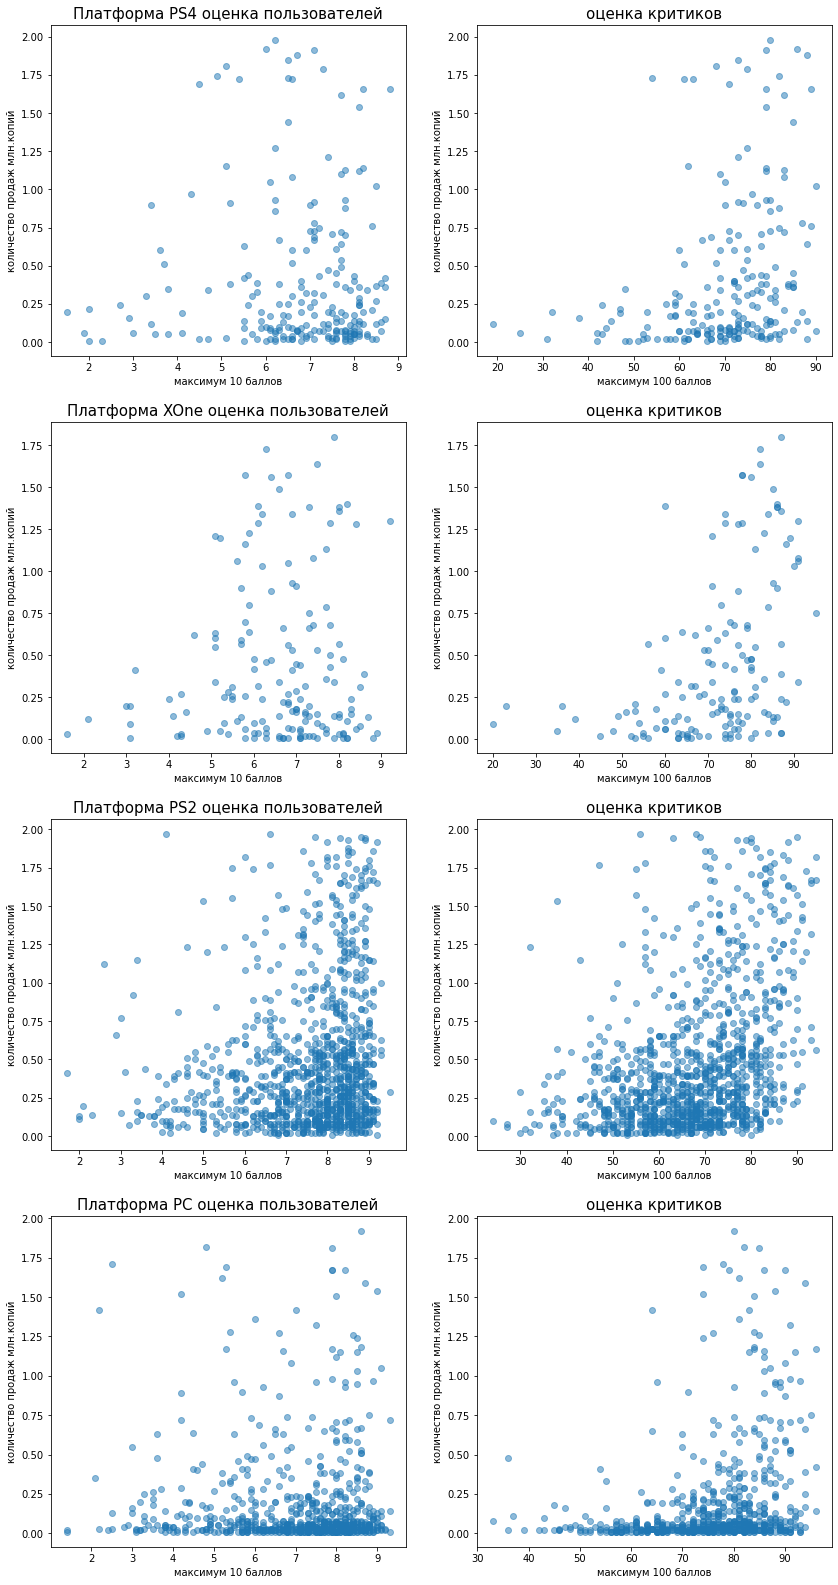

In [29]:
f, axs = plt.subplots(4, 2, figsize=(14, 28))
subplt = 0

#['PS4','WiiU','PS3','X360','3DS','XOne','PC','PSV','Wii']
for platforma in ['PS4','XOne','PS2','PC']:
# в цикле выбираем патформу и отрезаем все продажи выше 2 млн копий для нагладности     
    x= df_usecore[(df_usecore['platform']==platforma)&(df_usecore['cumul_sales']<2)]['user_score']
    y= df_usecore[(df_usecore['platform']==platforma)&(df_usecore['cumul_sales']<2)]['cumul_sales']
    axs[subplt,0].scatter(x,y, alpha=0.5)
    axs[subplt,0].set_xlabel('максимум 10 баллов')
    axs[subplt,0].set_ylabel('количество продаж млн.копий')
    axs[subplt,0].set_title('Платформа '+platforma+' оценка пользователей', fontsize=15)
    x= df_criticore[(df_criticore['platform']==platforma)&(df_criticore['cumul_sales']<2)]['critic_score']
    y= df_criticore[(df_criticore['platform']==platforma)&(df_criticore['cumul_sales']<2)]['cumul_sales']
    axs[subplt,1].scatter(x, y, alpha=0.5)
    axs[subplt,1].set_xlabel('максимум 100 баллов')
    axs[subplt,1].set_ylabel('количество продаж млн.копий');
    axs[subplt,1].set_title('оценка критиков', fontsize=15)
    subplt += 1
    
plt.show;  

In [30]:
print('Коэффициенты корреляции между оценками пользователей и критиков и количеством проданных игр различных платформ:')
for platforma in ['PS4','XOne','PS2','PC']:
    print(platforma,' -  По оценке пользователей :{:.2f} по оценке критиков: {:.2f}'.
          format(df_usecore[df_usecore['platform']==platforma]['user_score'].corr(df_usecore[df_usecore['platform']==platforma]['cumul_sales']),
                 df_criticore[df_criticore['platform']==platforma]['critic_score'].corr(df_criticore[df_criticore['platform']==platforma]['cumul_sales']))                                                                )
                

Коэффициенты корреляции между оценками пользователей и критиков и количеством проданных игр различных платформ:
PS4  -  По оценке пользователей :-0.03 по оценке критиков: 0.41
XOne  -  По оценке пользователей :-0.07 по оценке критиков: 0.42
PS2  -  По оценке пользователей :0.17 по оценке критиков: 0.40
PC  -  По оценке пользователей :0.01 по оценке критиков: 0.26


### Вывод 
Видим слабые и очень слабые разнознаковые корреляции, которые говорят о том, что прямой, линейной корреляции нет, особенно в части пользовательских оценок. Но связь явно есть, если посмотреть на графики scatter то распределение точек чем то напоминает степенную функцию, типа 'x = a + к в степени y'. Видно, что более высокие рейтинги имеют более продаваемые игры, и наоборот, лушие продажи игр при более высоких рейтингах.

Примечательно то, что коэффициент корреляции пользовательски оценок растущих платформ, хоть и близок к нулю, всё же отрицательный, а "старых" платформ наоборот. Можно предположить, что оценки пользователей субъективны и на них оказывает влияние а) Отрицание нового б) Игры платформы еще не распробованы на начальном этапе. в)Положительная оценка зависит от продаж (разкрученности), т.есть, - "игра крута, потому что она крута".   Коэффициент корреляции оценок критиков слабый, но всё же положительный и близок к критической границе 0.5, значит сами оценки менее субъективны, и всё таки имеют какое то прямое влияние на продажи.

**Комментарий** Смотрим наиболее и наименее продаваемые игровые жанры. 

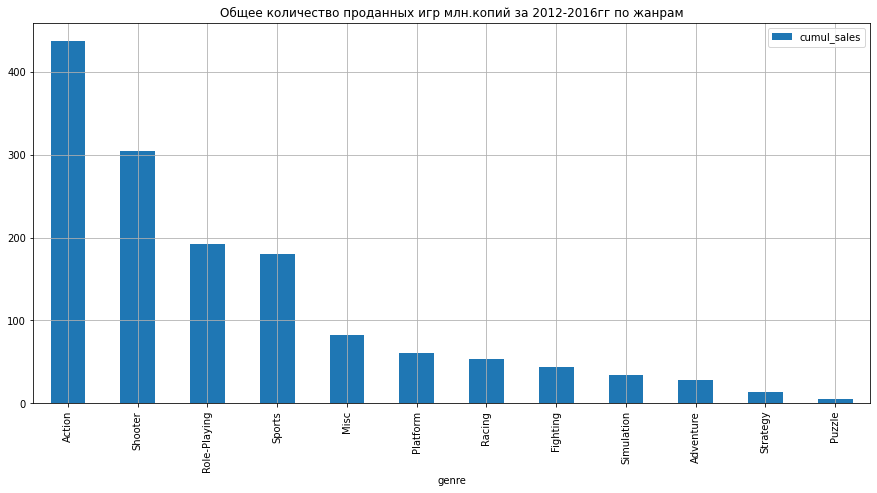

In [31]:
(
    df_actuel.pivot_table(index = 'genre', values = 'cumul_sales', aggfunc = 'sum').
    sort_values(by = 'cumul_sales',ascending = False).
    plot(grid=True,figsize=(15,7), kind = 'bar', title='Общее количество проданных игр млн.копий за 2012-2016гг по жанрам')
);

### Вывод 
Наибольшее количество проданных копий в жанрах Action, Sports, Shooter и Role-Playing. Самое малое количество проданных копий в жанре Puzzle . Разница между лидером более чем в 10 раз. Причем эта разница выросла за последние 10 лет. Сказывается увеличение аппартных мощностей.

## Анализ пользовательских предпочтений разных регионов

**Комментарий** Определяем приоритетные игровые платформы для трех представленных регионов: Японии, Европы и Северной Америки.
Формируем сводную таблицу и выводим ее на экран.

In [32]:
# делаем сводную таблицу по игровым платформам и продажам Японии. Европы и Северной Америки
df_platform = df_actuel.pivot_table(index = 'platform', values =['na_sales','eu_sales','jp_sales'], aggfunc='sum')

# считаем доли продаж по регионам и округляем их до 2-х знаков, для внешней привлекательности
df_platform['na_ratio'] = round(df_platform['na_sales']/df_platform['na_sales'].sum(),2)
df_platform['eu_ratio'] = round(df_platform['eu_sales']/df_platform['eu_sales'].sum(),2)
df_platform['jp_ratio'] = round(df_platform['jp_sales']/df_platform['jp_sales'].sum(),2)

# сосбственно самый нужный столбец с названиями платформ, возвращаем из индексов в данные
df_platform['platform'] = df_platform.index

# Выделяем необходимые нам данные в отдельные, отсортированные по доле продаж небольшие датафреймы-срезы из 5-ти строк
df_eu = df_platform[['platform','eu_sales','eu_ratio']].sort_values(by='eu_ratio', ascending=False).iloc[0:5]
df_na = df_platform[['platform','na_sales','na_ratio']].sort_values(by='na_ratio', ascending=False).iloc[0:5]
df_jp = df_platform[['platform','jp_sales','jp_ratio']].sort_values(by='jp_ratio', ascending=False).iloc[0:5]

# Приводим в порядок индексы перед слиянием в общую таблицу
df_eu.reset_index(inplace = True, drop = True)
df_na.reset_index(inplace = True, drop = True)
df_jp.reset_index(inplace = True, drop = True)

# Собираем срезы в одну общую таблицу для наглядности
df_region = pd.concat([df_eu,df_na,df_jp],sort=False,axis=1)

# Приводим в порядок наименования столбцов
df_region.columns = ['top5_Europa','eu_sales','eu_ratio','top5_North_America','na_sales','na_ratio','top5_Japan','jp_sales','jp_ratio']

print()
display('            ТОП  5  самых продаваемых игровых платформ за 2011 - 2016гг:')
display(df_region)
print()

'            ТОП  5  самых продаваемых игровых платформ за 2011 - 2016гг:'

,top5_Europa,eu_sales,eu_ratio,top5_North_America,na_sales,na_ratio,top5_Japan,jp_sales,jp_ratio
0,PS4,141.09,0.28,X360,139.16,0.24,3DS,87.68,0.46
1,PS3,106.26,0.21,PS4,108.62,0.19,PS3,34.92,0.18
2,X360,74.02,0.15,PS3,103.10,0.18,PSV,20.93,0.11
3,XOne,51.43,0.10,XOne,92.77,0.16,PS4,15.96,0.08
4,3DS,41.64,0.08,3DS,54.65,0.09,WiiU,13.01,0.07


### Вывод 
Предпочтения европейских пользователей почти равномерно распределены между игровыми платформами PS4 и PS3, в Северной Америке фаворитом является XBox360 с небольшим отрывом от PS3 и PS4.В Японии колоссальное преимущество у 3DS, этим она заметно отличается от двух других регионов, кроме того на 3м месте такая платформа как PSV (PS Vita - портативная игровая приставка), которая не входи в топ ни в Америке ни в Европе. Портативные игровые приставки в Японии имеют огромное преимущество перед стационарами. Возможно Японцы не любят сидеть на месте и играют в пути ???

Определяем приоритетные игровые жанры для трех регионов, также с помощью сводной таблицы выводимой на экран:

In [33]:
# делаем сводную таблицу по игровым жанрам и продажам Японии. Европы и Северной Америки
df_genre = df_actuel.pivot_table(index = 'genre', values =['na_sales','eu_sales','jp_sales'], aggfunc='sum')

# считаем доли продаж по регионам и округляем их до 2-х знаков, для внешней привлекательности
df_genre['na_ratio'] = round(df_genre['na_sales']/df_genre['na_sales'].sum(),2)
df_genre['eu_ratio'] = round(df_genre['eu_sales']/df_genre['eu_sales'].sum(),2)
df_genre['jp_ratio'] = round(df_genre['jp_sales']/df_genre['jp_sales'].sum(),2)

# сосбственно самый нужный столбец с жанрами, возвращаем из индексов в данные
df_genre['genre'] = df_genre.index

# Выделяем необходимые нам данные в отдельные, отсортированные по доле продаж небольшие датафреймы-срезы из 5-ти строк
df_eu = df_genre[['genre','eu_sales','eu_ratio']].sort_values(by='eu_ratio', ascending=False).iloc[0:5]
df_na = df_genre[['genre','na_sales','na_ratio']].sort_values(by='na_ratio', ascending=False).iloc[0:5]
df_jp = df_genre[['genre','jp_sales','jp_ratio']].sort_values(by='jp_ratio', ascending=False).iloc[0:5]

# Приводим в порядок индексы перед слиянием срезов в общую таблицу
df_eu.reset_index(inplace = True, drop = True)
df_na.reset_index(inplace = True, drop = True)
df_jp.reset_index(inplace = True, drop = True)

# Собираем срезы в одну общую таблицу для наглядности
df_region = pd.concat([df_eu,df_na,df_jp],sort=False,axis=1)

# Приводим в порядок наименования столбцов для вывода на экран
df_region.columns = ['top5_Europa','eu_sales','eu_ratio','top5_North_America','na_sales','na_ratio','top5_Japan','jp_sales','jp_ratio']
print()
display('           ТОП  5  самых продаваемых игровых жанров за 2011 - 2016гг :')
display(df_region)
print()

'           ТОП  5  самых продаваемых игровых жанров за 2011 - 2016гг :'

,top5_Europa,eu_sales,eu_ratio,top5_North_America,na_sales,na_ratio,top5_Japan,jp_sales,jp_ratio
0,Action,157.76,0.31,Action,176.45,0.30,Role-Playing,65.44,0.34
1,Shooter,113.33,0.23,Shooter,144.64,0.25,Action,52.33,0.27
2,Sports,68.69,0.14,Sports,81.13,0.14,Misc,12.86,0.07
3,Role-Playing,48.53,0.10,Role-Playing,64.00,0.11,Fighting,9.41,0.05
4,Misc,24.84,0.05,Misc,36.90,0.06,Platform,8.63,0.05


### Вывод 
Предпочтения европейских и Американских потребителей отданы играм в стиле Экшн и Шутерам, а в Японии колоссальное преимущество у Ролевых игр, хотя Экшены также пользуются хорошим спросом. А вот шутеры, не очень. Кроме того, у Японцев в ТОП5 отсутствуют спортивные компьютерные игры, которые у Европейцев с Американцами занимают более 10% продаж.

**Комментарий** Анализируем зависимость продаж игр от рейтинга ESRB. Для оценки берем данные по актуальному периоду 2012-2016 год из датафрейма df_actuel

In [34]:
#строим сводную таблицу по Японии
rating_jp = df_actuel.pivot_table(index = 'rating', values = 'jp_sales', aggfunc=('sum','count'))

#считаем колонку 'ratio' с долей проданных игр в зависимости от типа рейтинга и без него
rating_jp['ratio'] = round(rating_jp['sum']/rating_jp['count'],2)

#сортируем по доле
rating_jp = rating_jp.sort_values(by = 'ratio', ascending = False)
display(rating_jp)

,count,sum,ratio
rating,,,
not_rating,1259,108.84,0.09
E,340,28.09,0.08
T,394,25.55,0.06
M,494,21.20,0.04
E10+,268,8.06,0.03


In [35]:
#строим и выводим сводную таблицу по Северной Америке
rating_na = df_actuel.pivot_table(index = 'rating', values = 'na_sales', aggfunc=('sum','count'))

#считаем колонку 'ratio' с долей проданных игр 
rating_na['ratio'] = round(rating_na['sum']/rating_na['count'],2)

#сортируем по доле
rating_na = rating_na.sort_values(by = 'ratio', ascending = False)
display(rating_na)

,count,sum,ratio
rating,,,
M,494,231.53,0.47
E,340,112.92,0.33
E10+,268,73.29,0.27
T,394,65.80,0.17
not_rating,1259,103.27,0.08


In [36]:
#строим и выводим сводную таблицу по Европе
rating_eu = df_actuel.pivot_table(index = 'rating', values = 'eu_sales', aggfunc=('sum','count'))

#считаем колонку 'ratio' с долей проданных игр 
rating_eu['ratio'] = round(rating_eu['sum']/rating_eu['count'],2)

#сортируем по доле и выводим результат
rating_eu = rating_eu.sort_values(by = 'ratio', ascending = False)
display(rating_eu)

,count,sum,ratio
rating,,,
M,494,194.19,0.39
E,340,110.95,0.33
E10+,268,52.48,0.20
T,394,52.82,0.13
not_rating,1259,91.24,0.07


**Рейтинги ESRB**

Е - для всех
Е10+ - для всех от 10 лет и старше
Т - подросткам от 13 лет
М - для взрослых от 17 лет

Стандарт необязательно, но активно внедряемый. Был принят в США и Канаде, где он и известен больше всего. Видимо оттуда распространился в Европу. 

### Вывод 

Как видно из таблиц, в Японии рейтинги не работают. Возможно это связано с определенным менталитетом, возможно с тем, что в Японии другие возрастные границы и понимание того, что к этим граница относится, а скорее всего потому, что рейтинги ESRB это чисто Северо-Американское "изобретение" предназначенное для игр распространяемых на этой и зависимых от этого рынка территориях, как например в Европе. Предполагаю, что в Японии есть свои критерии и рейтинги для оценки выпускаемых игр, но их нет в этой базе. 

## Проверка гипотез

**5.1** Формулируем гипотезу
H0: Cредние пользовательские рейтинги для платформ Xbox One и PC равны
H1: Cредние пользовательские рейтинги для платформ Xbox One и PC не равны 

In [37]:
# df_xbox, df_pc, df_action, df_sports  датафреймы-срезы  по соответствующим платформам и жанрам
 
df_xone = df_usecore[df_usecore['platform']=='XOne']
df_pc = df_usecore[df_usecore['platform']=='PC']
df_action = df_usecore[df_usecore['genre']=='Action']
df_sports = df_usecore[df_usecore['genre']=='Sports']
 
alpha = 0.05  
# уточнение дисперсий
print('дисперсии выборок: для Xbox One {:.2f} для PC {:.2f}'.format(np.var(df_xone['user_score']), np.var(df_pc['user_score'])))

# дисперсии близки, поэтому параметр  equal_var не используем 
results = st.ttest_ind(df_xone['user_score'], df_pc['user_score'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('вероятность получить ожидаемый результат низка, отвергаем нулевую гипотезу')
else:
    print('вероятность получить ожидаемый результат высока, не получилось отвергнуть нулевую гипотезу') 



дисперсии выборок: для Xbox One 1.90 для PC 2.34
p-значение: 4.935072360183565e-06
вероятность получить ожидаемый результат низка, отвергаем нулевую гипотезу


**5.2** Формулируем гипотезу
H0: Средние пользовательские рейтинги для жанров Action и Sport равны  
H1: Средние польховательские рейтинги для жанров Action и Sport не равны (отличаются, разные)

In [38]:
alpha = 0.05  
# уточнение дисперсий
print('дисперсии выборок: для Action {:.2f} для Sport {:.2f}'.format(np.var(df_action['user_score']), np.var(df_sports['user_score'])))

# дисперсии отличаются  
results = st.ttest_ind(df_action['user_score'], df_sports['user_score'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('вероятность получить ожидаемый результат низка, отвергаем нулевую гипотезу')
else:
    print('вероятность получить ожидаемый результат высока, не получилось отвергнуть нулевую гипотезу') 



дисперсии выборок: для Action 2.03 для Sport 2.59
p-значение: 0.11483818791498286
вероятность получить ожидаемый результат высока, не получилось отвергнуть нулевую гипотезу


### Вывод
1. Считаем что генеральные совокупности, а значит и предложенные нами выборки данных с выручкой независимыми.
2. Количество значений в каждой из наших выборок больше двухсот, и в соответствии с ЦПТ можно считать, что выборочные средние рапределены нормально.
3. Нулевые гипотезы в обоих примерах формулируем о равенстве средних.
4. Пороговое значение alpha выбрано 0.05
5. С учетом п.1 и п.2, для проверки гипотезы о равенсиве среднего двух генеральных совокупностей по их выборкам используем метод st.ttest_ind. В обоих случаях метод используем с учетом неравенства дисперсий.
6. Гипотеза о равенстве cредних пользовательских рейтингов для платформ Xbox One и PC была отвергнута.
7. Гипотеза о равенстве средних пользовательских рейтингов для жанров Action и Sport не отвергнута.

## Общий вывод

Проведен предварительный анализ анализ данных, намечены пути обработки колонок таблиц и их дальнейшего использования. Проведена предварительная подготовка данных в таблицах - проведены проверки на выявление дубликатов, исправлены названия колонок, удалены пропуски в колонке name, заменены пропуски в колонках year_of_release и rating. Изменены форматы данных в колонках user_score и year_of_release. Создана колонка cumul_sales с общим количеством реализованных игр всех регионов.

Cозданы рабочие датафреймы df (1992 - 2016гг) df_actuel (2012-2016), df_usecore и df_criticore с пользовательскими и критическими рейтингами игр. Эти таблицы в дальнейшем использовались для анализа данных. 

Анализировались следующие показатели:

Анализ количество выпускаемых игр по годам выявил незначительные выпуски игр для игровых платформ в период до 1991 года. Результатом данных этого периода можно пренебречь. Выяснилось также, что в период до 1994 года не велась статистика по рейтингам всех видов, это стало одним из следствий большого количества пустот в колонках critic_score, user_score, rating

Цикл жизни игровой платформы. Составляет 9 - 11 лет. За это время платформа появляется, растет, затем падает и исчезает.При этом 4-5 лет рост, затем 1-2 года пик продаж и 4 - 5 лет падение. Можно предсказать на каком этапе жизненного цикла сейчас находится игровая платформа если есть полные данные о количестве проданных копий за последние 4-5 лет. Поэтому актуальный
период принимаем за 5 лет

Анализируя актуальный период, определены перспективные игровые платформы на 2017 год PS4 и XOne. 
Статистика продаж перспективных игровых платформ очень обширна, от 10 тыс копий до 14 млн. При этом большое значение имеют звезды, уровень продаж которых исчисляется миллионами. У обоих топовых платформ среднее количество проданных игр отличается от медианы в несколько раз у PS4 в 4 раза, у XOne в 2 раза. Общее количество выпущенных игр за 5 лет около 300 у каждой платформы и если рассматривать цикл жизни, то до конца их существования ожидается примерно столько же. Обе платформе приближаются к своему пику.

Анализируя boxplot "старых" платформ (PS2, PC) можно сделать вывод, что основная часть игр имеет короткий жизненный цикл, зато есть "звезды" продолжают продаваться весь цикл существования платформы, наверное до тех пор, пока существует техническая поддержка аппаратной части платформ. Из этого можно сделать вывод о том, что даже если количество продаваемых и выпускаемых игр игровой платформы падает и она находится на завершающем этапе жизни, некоторое время можно вкладываться в ТОПовые игры. 

Существует зависимость между количеством проданных копий игр и рейтингами критиков и пользователей. 
Cлабые и очень слабые разнознаковые коэффициенты корреляции, которые говорят о том, что прямой, линейной корреляции нет, особенно в части пользовательских оценок, корреляция близка к нулю. Но связь явно есть. Видно, что более высокие рейтинги имеют более продаваемые игры, и наоборот, лушие продажи игр при более высоких рейтингах. Примечательно то, что коэффициент корреляции пользовательски оценок растущих платформ, хоть и близок к нулю, всё же отрицательный, а "старых" платформ наоборот. Можно предположить, что оценки пользователей субъективны и зависят времени. Коэффициент корреляции оценок критиков также слабый, но всё же положительный и близок к критической границе 0.5, значит сами оценки менее субъективны, и всё таки имеют не нулевое линейное влияние на продажи.

Прямой корреляции нет, темне менее чем выше рейтинг, тем большее количество копий игр продается.

Самыми продаваемыми игровыми жанрами в период 2012-2016 год были  Action, Sports, Shooter и Role-Playing. Самое малое количество проданных копий в жанре Puzzle и Strategy. Разница между лидером более чем в 10 раз. Причем эта разница выросла за последние 10 лет. Сказывается увеличение аппартных мощностей.

Предпочтения европейских пользователей почти равномерно распределены между игровыми платформами PS4 и PS3, в Северной Америке фаворитом является XBox360 с небольшим отрывом от PS3 и PS4.В Японии же колоссальное преимущество у мобильных платформ 3DS и PSV больше половины всех продаваемых игр в Японии были для этих игровых приставок.Возможно Японцы не любят сидеть на месте и играют в пути ???

В игровых жанрах Японцы также сильно отличаются, они отдают предпочтения ролевым играм, на втором месте Action, в Европе и Америке наоборот Action бесспорный лидер, а ролевые только на 4м месте.

Американо-Канадский рейтинг ESRB никак не влияет на продажи в Японии, зато развит и используется в Европе и Северной Америке. Без рейтинга там продается всего 7-8 % игр, большая часть продаваемых игр из категории М (игры для взрослых от 17лет)

Гипотеза о том что: Средние пользовательские рейтинги платформ XBox One и PC равны отвергнута. Не отвергнута альтернативная гипотеза о том, что Средние пользовательские рейтинги платформа XBox One и PC не равны.

Гипотеза о том, что: Средние пользовательские рейтинги для жанров Action и Sports равны  не отвергнута. Отвергнута альтернативная нипотеза о том, что Средние пользовательские рейтинги для жанров Action и Sports не равны.